*This notebook can be found on* [github](https://github.com/qojulia/QuantumOptics.jl-examples/tree/master/notebooks/ramsey.ipynb)

Ramsey spectroscopy of two-level atom ensemble
=========================

In [1]:
using QuantumOptics
using PyPlot

Consider an ensemble of two-level atoms (spin-1/2 particles) with transition frequency $\omega_{a}$ subject to decay. The Hamiltonian of the system is

$H_{at} = \frac{\Delta}{2}\sum_i\sigma_i^z,$

where $\Delta = \omega_a - \omega_l$ and $\omega_l$ is a reference frequency.
We describe the decay with rate $\gamma$ via the Lindblad term

$\mathcal{L}[\rho] = \frac{\gamma}{2}\sum_i\left(2\sigma_i^-\rho\sigma_i^+ - \sigma_i^+\sigma_i^-\rho - \rho\sigma_i^+\sigma_i^-\right).$

Say we want to perform a Ramsey interferometry scheme on this ensemble. This is done in three stages:

1) A laser pulse (laser frequency $\omega_l$) with amplitude $\eta$ is applied for a time $T$ such that $\eta T=\frac{\pi}{4}$ ($\pi/2$-pulse).

2) The ensemble is left to evolve freely under the Hamiltonian $H_{at}$ and the Liouvillian $\mathcal{L}[\rho]$.

3) Finally, another $\pi/2$-pulse is applied and the total population inversion $\sum_i\langle\sigma_i^z\rangle$ is measured.

In [2]:
N = 2 # Atom number
γ = 0.1 # Decay rate
Δ = 0.2 # Detuning
η = 15.0 # Pulse strength

T = π/4η # Length for pulse
Tsteps = 101
Tlist = Vector(linspace(0, T, Tsteps))

τ = 0.5/γ # Length of free time evolution
τsteps = 201
τlist = Vector(linspace(0, τ, τsteps))

b_atom = SpinBasis(1//2)
b_coll = tensor([b_atom for i=1:N]...);

In [3]:
sm(i) = embed(b_coll, i, sigmam(b_atom))
sp(i) = embed(b_coll, i, sigmap(b_atom))
sz(i) = embed(b_coll, i, sigmaz(b_atom));

In [4]:
H_at = 0.5Δ*sum(sz.(1:N;));

The Hamiltonian of the driving laser is $H_l = \eta\sum_i\left(\sigma_i^- + \sigma_i^+\right).$

In [5]:
H_l = η*sum(sm.(1:N;) + sp.(1:N;));

J = [sm(i) for i=1:N]
rates = [γ for i=1:N];

**1) First $\pi/2$-pulse**

In [6]:
ψ₀ = tensor([spindown(b_atom) for i=1:N]...)

Tout, ρT = timeevolution.master(Tlist, ψ₀, H_at + H_l, J; rates=rates);

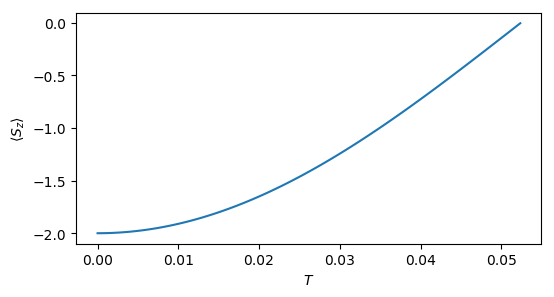

In [7]:
inv_π2 = sum([real(expect(sz(i), ρT)) for i=1:N])

figure(figsize=(6, 3))
plot(Tout, inv_π2)
xlabel(L"$T$")
ylabel(L"$\langle S_z\rangle$")

ρπ2 = ρT[end]; # State after first π/2-pulse

**2) Free time evolution**

In [8]:
τout, ρτ = timeevolution.master(τlist, ρπ2, H_at, J; rates=rates);

ρm = ρτ[end]; # State after free time evolution

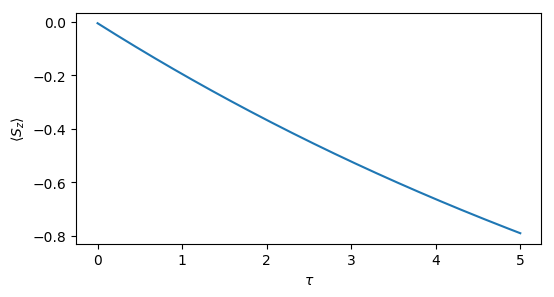

In [9]:
inv_τ = sum([real(expect(sz(i), ρτ)) for i=1:N])

figure(figsize=(6, 3))
plot(τout, inv_τ)
xlabel(L"$\tau$")
ylabel(L"$\langle S_z\rangle$");

**3) Second $\pi$-2 pulse**

In [10]:
Tout, ρT = timeevolution.master(Tlist, ρm, H_at + H_l, J; rates=rates);

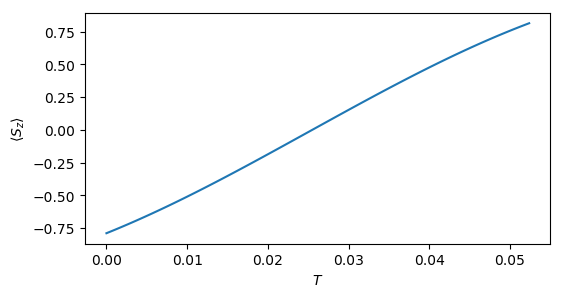

In [11]:
inv_π = sum([real(expect(sz(i), ρT)) for i=1:N])

figure(figsize=(6, 3))
plot(Tout, inv_π)
xlabel(L"$T$")
ylabel(L"$\langle S_z\rangle$")

ρπ = ρT[end]; # Final state after second π/2-pulse

As you can see, for the chosen parameters we end up in a state near the fully inverted one.

Ramsey fringes
=============

Now, in order to obtain the famous Ramsey fringes, we have to scan over the laser frequency, i.e. the detuning. To this end, we need to do the entire above procedure but for different detunings.

Let's write a function for the above procedure but allowing for different detunings that returns the final population inversion.

In [12]:
Sz = sum(sz.(1:N))

function ramsey(Δ)
    H_at = 0.5Δ*Sz
    Tout, ρ1 = timeevolution.master(Tlist, ψ₀, H_at + H_l, J; rates=rates) # First π/2-pulse
    τout, ρτ = timeevolution.master(τlist, ρ1[end], H_at, J; rates=rates) # Free time evolution
    Tout, ρ2 = timeevolution.master(Tlist, ρτ[end], H_at + H_l, J; rates=rates) # Second π/2-pulse
    real(expect(Sz, ρ2[end])) # Return resulting final inversion
end;

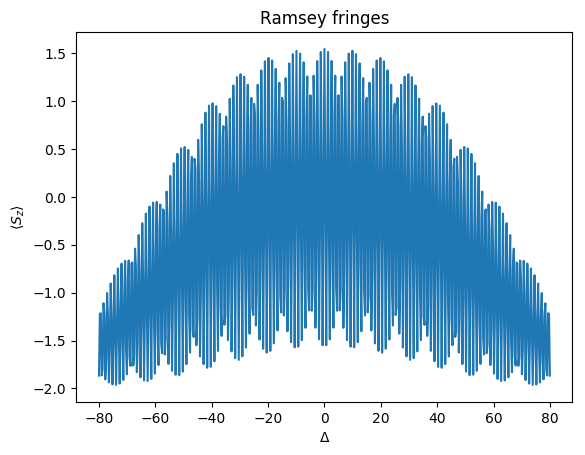

In [13]:
Δ_ls = Vector(linspace(-80, 80, 501)) # List of detunings

Sz_exp = ramsey.(Δ_ls)

plot(Δ_ls, Sz_exp)
ylabel(L"$\langle S_z\rangle$")
xlabel(L"$\Delta$")
title("Ramsey fringes");

In [18]:
T_rabi = Vector(linspace(0, 2T, 301))

function rabi(Δ)
    H_at = 0.5Δ*Sz
    Tout, ρT = timeevolution.master(T_rabi, ψ₀, H_at + H_l, J; rates=rates)
    real(expect(Sz, ρT[end]))
end;

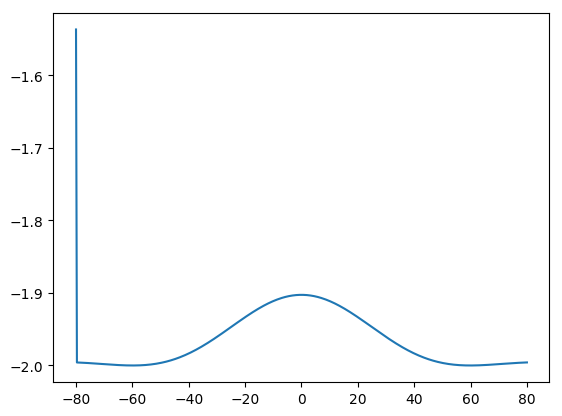

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcae1876f50>

In [19]:
plot(Δ_ls, rabi.(Δ_ls))